## Imports

In [1]:
import sys
import os
import math

In [2]:
import serial
import time

In [3]:
import pyvisa

In [4]:
import numpy as np
import pandas as pd

In [5]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

# Library

In [6]:
! python -m serial.tools.list_ports

COM3                
COM4                
COM5                


3 ports found


## Switch

In [7]:
def setupInputSwitch():
    global inputSwitch
    inputSwitch = serial.Serial()
    inputSwitch.port = 'COM4'
    inputSwitch.close()
    inputSwitch.open()
    time.sleep(0.5)
    response = inputSwitch.read_all()
    print(response.decode("utf-8"))

In [8]:
def setupOutputSwitch():
    global outputSwitch
    outputSwitch = serial.Serial()
    outputSwitch.port = 'COM3'
    outputSwitch.close()
    outputSwitch.open()
    time.sleep(0.5)
    response = outputSwitch.read_all()
    print(response.decode("utf-8"))

In [9]:
def setInputSwitch(i, verbose=False):
    inputSwitch.flushInput()
    inputSwitch.write(str.encode(str(i)))
    if verbose:
        time.sleep(2)
        response = inputSwitch.read_all()
        print(response.decode("utf-8"))

In [10]:
def setOutputSwitch(i, verbose=False):
    outputSwitch.flushInput()
    outputSwitch.write(str.encode(str(i)))
    if verbose:
        time.sleep(2)
        response = outputSwitch.read_all()
        print(response.decode("utf-8"))

In [11]:
def closeInputSwitch():
    inputSwitch.close()

In [12]:
def closeOutputSwitch():
    outputSwitch.close()

## MCUs

In [13]:
def setupMCU():
    global MCU
    MCU = serial.Serial()
    MCU.port = 'COM5'
    MCU.close()
    MCU.open()
    time.sleep(0.5)
    response = MCU.read_all()
    print(response.decode("utf-8"))

In [14]:
def setMCU(i, v1, v2, verbose=False):
    """
    i = MCU idNum
    v1 = VGA
    v2 = PS
    versbose - print status
    """
    MCU.flushInput()
    if isinstance(v1, float):
        v1Out = int(v1)
    else:
        v1Out = v1
    if isinstance(v2, float):
        v2Out = int(v2)
    else:
        v2Out = v2
    v1Out = np.clip(v1Out, 1, 1023)
    v2Out = np.clip(v2Out, 1, 1023)
    MCU.write(str.encode(str(i)+' 2 '+str(v1Out)+' '+str(v2Out)))
    if verbose:
        time.sleep(1)
        response = MCU.read_all()
        print(response.decode("utf-8"))

In [15]:
def setAllMCU(data, verbose=False):
    """
    data is expected to be of the form np.array([[v1,v2], [v1,v2], ... ])
    """
    nMCUs = data.shape[0]
    iMCUs = (np.arange(nMCUs)+1).tolist()
    for i in iMCUs:
        v1, v2 = data[i-1]
        setMCU(i, v1, v2, verbose)
        time.sleep(0.2)

In [16]:
def blinkMCU(i, verbose=False):
    MCU.flushInput()
    MCU.write(str.encode(str(i)+' 1'))
    if verbose:
        time.sleep(2)
        response = MCU.read_all()
        print(response.decode("utf-8"))

In [17]:
def blinkAll(iMax, verbose=False):
    iMaster = 255
    iMCUs = (np.arange(iMax)+1).tolist()
    iAll = [iMaster] + iMCUs 
    for i in iAll:
        blinkMCU(i, verbose)
        time.sleep(5.5) # Needed wait time to allow MCU to return to listenting state.

In [40]:
blinkAll(5)

In [18]:
def closeMCU():
    MCU.close()

## VNA

In [19]:
def setupVNA():
    global inst
    rm = pyvisa.ResourceManager()
    resources = rm.list_resources()
    inst = rm.open_resource(resources[0])
    name = inst.query('*IDN?')
    print(name)

In [20]:
def getS21at45():
    """
    VNA state 8
    """
    inst.write('MMEM:STOR:FDAT "d:/dummy.csv"')
    result = inst.query('MMEM:TRAN? "d:/dummy.csv"')
    impArray = pd.read_csv(StringIO(result), skiprows = 2).to_numpy()
    r = impArray[round((len(impArray)-1)/2), 1]
    i = impArray[round((len(impArray)-1)/2), 2]
    return r + 1j*i

In [21]:
def getS21AllAt45():
    """
    For use with VNA State 7
    """
    inst.write('MMEM:STOR:FDAT "d:/dummy.csv"')
    result = inst.query('MMEM:TRAN? "d:/dummy.csv"')
    impArray = pd.read_csv(StringIO(result), skiprows = 2).to_numpy()
    rvs = impArray[:,1]
    ivs = impArray[:,2]
    zvs = rvs + 1j*ivs
    zAve = np.mean(zvs)
    zSTD = np.std(zvs)
    return (zAve, zSTD)

In [22]:
def getS21freq():
    inst.write('MMEM:STOR:FDAT "d:/dummy.csv"')
    result = inst.query('MMEM:TRAN? "d:/dummy.csv"')
    impArray = pd.read_csv(StringIO(result), skiprows = 2).to_numpy()
    r = impArray[range(len(impArray)), 1]
    i = impArray[range(len(impArray)), 2]
    return r + 1j*i

In [23]:
def closeVNA():
    inst.close()

# Application

## Setup

In [24]:
try:
    inputSwitch.close()
except:
    pass

In [25]:
try:
    outputSwitch.close()
except:
    pass

In [26]:
try:
    MCU.close()
except:
    pass

In [27]:
setupInputSwitch()

In [28]:
setupOutputSwitch()

In [29]:
setupMCU()

In [30]:
setupVNA()

Agilent Technologies,E5071C,MY46100333,A.07.02



In [381]:
setInputSwitch(2)
setOutputSwitch(2)

In [405]:
setMCU(4,837,489)

In [406]:
getS21AllAt45()

((-1.0014503673264266-0.012012922765367928j), 0.07835909380503399)

In [407]:
t22,tstd=getS21AllAt45()

In [408]:
r=np.array( [[1,-1j] , [1j,-1]] , dtype='complex')
t=np.array( [[t11,t12] , [t21,t22]], dtype='complex')

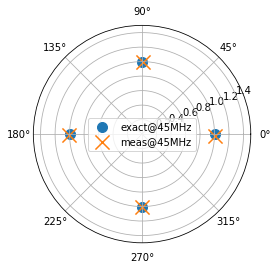

In [412]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
s1=ax.scatter(np.angle(r),np.abs(r),s=100,label='exact@45MHz')
s2=ax.scatter(np.angle(t),np.abs(t),s=200,marker='x',label='meas@45MHz')
plt.ylim([0,1.5])
ax.legend()
fig.savefig('AWR_Multiplier/2by2.png',dpi=600)

In [299]:
AWRcase3=np.loadtxt('AWR_Multiplier/case3_N.txt')
case3_z=AWRcase3[:,1]+1j*AWRcase3[:,2]
AWRcase2=np.loadtxt('AWR_Multiplier/case2_N.txt')
case2_z=AWRcase2[:,1]+1j*AWRcase2[:,2]
AWRcase1=np.loadtxt('AWR_Multiplier/case1_N.txt')
case1_z=AWRcase1[:,1]+1j*AWRcase1[:,2]

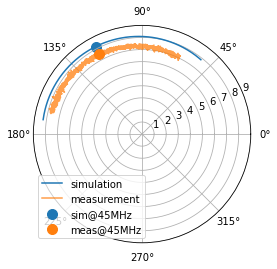

In [413]:

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
s1=ax.scatter(np.angle(case3_z[800]),np.abs(case3_z[800]),s=100,label='sim@45MHz')
s2=ax.scatter(np.angle(s213[800]),np.abs(s213[800]),s=100,marker='o',label='meas@45MHz')
c1=ax.plot(np.angle(case3_z),np.abs(case3_z),label='simulation')
c2=ax.plot(np.angle(s213),np.abs(s213),label='measurement',alpha=0.75)
ax.legend()
#ax.legend((s1, s2, c1, c2), ('label1', 'label2', 'label3','test'))
plt.ylim([0,9])
plt.show()
fig.savefig('AWR_Multiplier/case3.png',dpi=600)

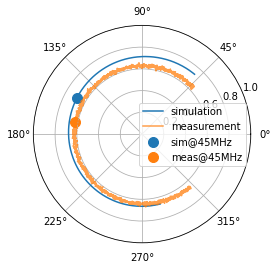

In [414]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
s1=ax.scatter(np.angle(case2_z[800]),np.abs(case2_z[800]),s=100,label='sim@45MHz')
s2=ax.scatter(np.angle(s212[800]),np.abs(s212[800]),s=100,marker='o',label='meas@45MHz')
c1=ax.plot(np.angle(case2_z),np.abs(case2_z),label='simulation')
c2=ax.plot(np.angle(s212),np.abs(s212),label='measurement',alpha=0.75)
ax.legend()
plt.ylim([0,1])
plt.show()
fig.savefig('AWR_Multiplier/case2.png',dpi=600)

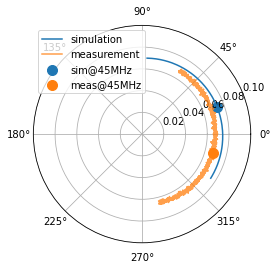

In [415]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
s1=ax.scatter(np.angle(case1_z[800]),np.abs(case1_z[800]),s=100,label='sim@45MHz')
s2=ax.scatter(np.angle(s211[800]),np.abs(s211[800]),s=100,marker='o',label='meas@45MHz')
c1=ax.plot(np.angle(case1_z),np.abs(case1_z),label='simulation')
c2=ax.plot(np.angle(s211),np.abs(s211),label='measurement',alpha=0.75)
ax.legend()
#ax.legend((s1, s2, c1, c2), ('label1', 'label2', 'label3','test'))
plt.ylim([0,.1])
plt.show()
fig.savefig('AWR_Multiplier/case1.png',dpi=600)

## Functions for characterization, interpolate, and save the data files

In [50]:
def CharacterizeMCU(i,s1,s2,Nv,Nps):
    """
    Function that characterizes the Multipliers.
    i= number fo MCU
    s1,s2 numbers of switch ports that are used
    Nv: values of voltages for the VGA.     
    Nps: voltage value for the phase shifter
    For best results try powers of 2
    """ 
    setInputSwitch(s1, False)
    setOutputSwitch(s2, False)
    NVGA=np.arange(start=0,stop=1023,step=1024/Nv, dtype='int')
    NP=np.arange(start=0,stop=1023,step=1024/Nps, dtype='int')
    sNVG=np.size(NVGA,0)
    sNPS=np.size(NP,0)
    TMat = np.zeros((sNVG,sNPS), dtype=np.complex)
    TMatSTD = np.zeros((sNVG,sNPS), dtype=np.complex)
    flag=0
    for ii in np.arange(sNVG):
        for ji in np.arange(sNPS):
            setMCU(i,NVGA[ii],NP[ji])
            time.sleep(1)
            (TMat[ii,ji], TMatSTD[ii,ji]) = getS21AllAt45()
            flag=flag+1
            print("\r{0}".format((float(flag)/sNVG**2)*100), end='\r', flush=True)
    print("DONE!")
    setMCU(i,1,1)
    Nv,Np=np.meshgrid(NVGA,NP)
    return(TMat,TMatSTD,Nv)

In [115]:
def setmesh():
    xnew = np.arange(start=0, stop=1023, step=1)
    ynew = np.arange(start=0, stop=1023, step=1)
    xxN,yyN=np.meshgrid(xnew,ynew)
    return(xnew,ynew,xxN,yyN)

In [120]:
def intDATA(Tinput):
    """
    Tinput: the required input data to be interpolated
    returns the interpolated data and the point new mesh
    """
    from scipy import interpolate
    zR=np.real(Tinput)
    zI=np.imag(Tinput)
    st=int(1024/np.sqrt(np.size(Tinput)))
    x=np.arange(start=0,stop=1023,step=st)
    y=np.arange(start=0,stop=1023,step=st)
    fR = interpolate.interp2d(x, y, zR, kind='cubic')
    fI = interpolate.interp2d(x, y, zI, kind='cubic')    
    (xnew,ynew,xxN,yyN)=setmesh()
    znew = fR(xnew, ynew)+1j*fI(xnew, ynew)
    return(znew,xxN)

In [117]:
def saveTXT(i,TMat,TMatSTD,Nv):
    """
    save retrieved date to .txt file
    TMat : complex s-param
    TMat : STD
    Nv: points grid (max 1024x1024)
    """
    size1=np.size(Nv,0)
    size2=np.size(Nv,1)
    np.savetxt('data/LMC6492_'+str(size1)+'by'+str(size2)+'_'+str(i)+'.txt', TMat)
    np.savetxt('data/LMC6492_'+str(size1)+'by'+str(size2)+'_'+str(i)+'STD.txt', TMatSTD)
    np.savetxt('data/LMC6492_'+str(size1)+'by'+str(size2)+'_'+str(i)+'Nv.txt', Nv)
    tint,Nvint=intDATA(TMat)
    tSTD,Nvint=intDATA(TMatSTD)
    size1i=np.size(Nvint,0)+1
    size2i=np.size(Nvint,1)+1
    np.savetxt('data/'+str(i)+'_'+str(size1i)+'by'+str(size2i)+'.txt', tint)
    np.savetxt('data/'+str(i)+'_'+str(size1i)+'by'+str(size2i)+'_STD.txt', tSTD)
    np.savetxt('data/'+str(i)+'_'+str(size1i)+'by'+str(size2i)+'_Nv.txt', Nvint)

In [ ]:
TMatT=np.loadtxt('LMC6492_64by64_5.txt', dtype='complex')
TMatTSTD=np.loadtxt('LMC6492_64by64_5STD.txt', dtype='complex')
TMATT,Nv1=intDATA(TMatT)
TMATTSTD,Nv1=intDATA(TMatTSTD)
saveTXT(5,TMATT,TMATTSTD,Nv1)

## Testing the new multipliers

In [54]:
def testMult(i):
    setInputSwitch(i,False)
    setOutputSwitch(i,False)
    table=np.zeros((9), dtype='complex')
    flag1,flag2=np.meshgrid([0,512,1023],[0,512,1023])
    f1=flag1.flatten()
    f2=flag2.flatten()
    for ii in np.arange(0,9):
            setMCU(i,f1[ii],f2[ii])
            table[ii],dumSTD=getS21AllAt45()
            time.sleep(1)
    return(table)

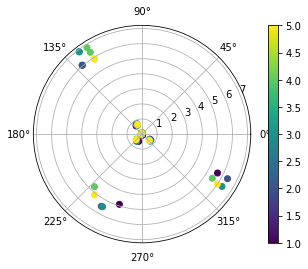

In [183]:
t1=testMult(1)
t2=testMult(2)
t3=testMult(3)
t4=testMult(4)
t5=testMult(5)
test=np.array([t1,t2,t3,t4,t5])
s=np.real(t1)*0
Cluster=np.array([s+1,s+2,s+3,s+4,s+5], dtype='int')
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
c=ax.scatter(np.angle(test),np.abs(test),c=Cluster,alpha=1)
plt.colorbar(c)
plt.show()

## Functions for setting and refining the MCU

In [111]:
def setComplex(i,TMat,z):
    '''
    Set a complex value on a given MCU
    based on an argmin function
    '''
    phase=math.exp(0)
    diff=abs(TMat-z)
    idx=(abs(diff)).argmin()
    (xnew,ynew,xxN,yyN)=setmesh()
    setMCU(i,yyN.flat[idx],xxN.flat[idx])
    time.sleep(1)
    return(yyN.flat[idx],xxN.flat[idx])

In [73]:
def measure5(N,ide,names):
    for i in np.arange(np.size(ide)):
        setMCU(ide[i],0,0)
        time.sleep(1)
        (TMat, TMatSTD, Nv) = CharacterizeMCU(ide[i],ide[i],ide[i],N,N)
        saveTXT(names[i],TMat,TMatSTD,Nv)
        time.sleep(1)

In [121]:
blinkAll(5)

In [185]:
measure5(128,[3,4,5],[23,24,25])

DONE!3896484375
DONE!3896484375
DONE!3896484375


In [65]:
print()

[0 1 2]


In [105]:
def dataAV(data):
    '''
    Statistics averaging function for the golden sample
    '''
    zAV=np.mean(data, axis=0)
    zSTD=np.std(data, axis=0)
    return(zAV,zSTD)

In [106]:
def take4(i,Nv,Np,M,N,tD):
    setMCU(i,Nv-M,Np-N)
    time.sleep(tD)
    z1,z1STD=getS21AllAt45()
    setMCU(i,Nv+M,Np-N)
    time.sleep(tD)
    z2,z2STD=getS21AllAt45()
    setMCU(i,Nv-M,Np+N)
    time.sleep(tD)
    z3,z3STD=getS21AllAt45()
    setMCU(i,Nv+M,Np+N)
    time.sleep(tD)
    z4,z3STD=getS21AllAt45()
    x=np.array([-M,M])
    y=np.array([-N,N])
    z=np.array([[z1,z2],[z3,z4]])
    return(x,y,z)

In [137]:
def setMCURefine(i,TMat,TMatSTD,zC,tD):
    Nv,Np = setComplex(i,TMat,zC)
    M=int(np.round(TMatSTD[Nv,Np]*20,0))
    N=int(np.round(TMatSTD[Nv,Np]*20,0))
    print(M,N)
    x,y,z=take4(i,Nv,Np,M,N,tD)
    from scipy import interpolate
    zR=np.real(z)
    zI=np.imag(z)
    xnew=np.arange(-M,M+1)
    ynew=np.arange(-N,N+1)
    fR = interpolate.interp2d(x, y, zR, kind='linear')
    fI = interpolate.interp2d(x, y, zI, kind='linear')    
    znew = fR(xnew, ynew)+1j*fI(xnew, ynew)
    d=abs(zC-znew)
    idx=d.argmin()
    xx,yy=np.meshgrid(xnew,ynew)
    print(Nv,Np)
    Nvnew=Nv+xx.flat[idx]
    Npnew=Np+yy.flat[idx]
    setMCU(i,Nvnew,Npnew)
    time.sleep(1)
    return(Nvnew,Npnew)

## Testing of the above functions

In [169]:
TMat16=np.loadtxt('data/16_1024by1024.txt', dtype='complex')
TMat17=np.loadtxt('data/17_1024by1024.txt', dtype='complex')
TMat18=np.loadtxt('data/18_1024by1024.txt', dtype='complex')
TMat19=np.loadtxt('data/19_1024by1024.txt', dtype='complex')
TMat20=np.loadtxt('data/20_1024by1024.txt', dtype='complex')

In [130]:
TMatAV,TMatAVSTD=dataAV([TMat11,TMat12,TMat13,TMat14,TMat15])


In [176]:
setInputSwitch(2,False)
setOutputSwitch(2,False)

In [181]:
z=2.82j
Nv,Np=setComplex(2,TMat17,z)
time.sleep(2)
zM,zMSTD=getS21AllAt45()
print(Nv,Np,abs(z-zM)/abs(z)*100)
zM

816 818 1.2598973600591674


(-0.03403675915969097+2.8098109682820733j)

In [182]:
setMCURefine(2,TMat17,TMatAVSTD,z,1)
zR,ZRSTD=getS21AllAt45()
print(abs(z-zR)/abs(z)*100)
zR

5 5
816 818
0.09778341979079196


(0.002751426645371248+2.820182800331842j)

# Playground and Measurements

In [ ]:
vga = 0.99+0.9/5*5**(0/5)*0
ps = 0.3
print("MCU Board ", ps/1023*5)
print("Mult Board", ps/946*13.53)
print(vga)
setMCU(4, 500, 100)

In [ ]:
a,b=getS21AllAt45()
print(abs(a))

In [ ]:
port=5
setInputSwitch(port)
setOutputSwitch(port)

In [ ]:
setMCU(4,0,0)

## Experiment

In [ ]:
te=np.arange(start=0,stop=1023,step=16)
pe=np.arange(start=0,stop=1023,step=16)
te1,te2=np.meshgrid(te,pe)
np.size(te1,0)
1024/1

In [ ]:
zSwitch1=np.array([[0,0],[0,0]], dtype="complex")
zSwitch1STD=np.array([[0,0],[0,0]], dtype="float")
zSwitch2=np.array([[0,0],[0,0]], dtype="complex")
zSwitch2STD=np.array([[0,0],[0,0]], dtype="float")

for i in [1,2]:
    for j in [1,2]:
        setInputSwitch(i,False)
        setOutputSwitch(j,False)
        time.sleep(2)
        zSwitch1[i-1,j-1],zSwitch1STD[i-1,j-1]=getS21AllAt45()
for i in [4,5]:
    for j in [4,5]:
        setInputSwitch(i,False)
        setOutputSwitch(j,False)
        time.sleep(2)
        zSwitch2[i-4,j-4],zSwitch2STD[i-4,j-4]=getS21AllAt45()
print(zSwitch1,zSwitch2)

In [ ]:
np.savetxt('3dB_couplers2.txt',np.array(zSwitch2))

In [ ]:
print(abs(zSwitch1)/(0.992*0.992),np.angle(zSwitch1)*180/math.pi+22)

In [ ]:
test=np.loadtxt('zSwitch.txt', dtype="complex")

In [ ]:
print(abs(test[0,0])/abs(zSwitch[0]),np.angle(test[0,0])*180/math.pi-np.angle(zSwitch[0])*180/math.pi)

In [ ]:
D_abs=abs(zSwitch[:])/abs(test[0,:])
D_angle=(np.angle(zSwitch[:])-np.angle(test[0,:]))*180/math.pi
print(D_abs,D_angle)

In [ ]:
setupInputSwitch()
setupOutputSwitch()

In [ ]:
saveTXT(5,TMATT,TMATTSTD,Nv1)

In [ ]:
TMAT1=intDATA(TMat1)
TMAT2=intDATA(TMat2)
TMAT3=intDATA(TMat3)
TMAT4=intDATA(TMat4)
TMAT5=intDATA(TMat5)
TMATAV=intDATA(TMatAV)

In [ ]:
setInputSwitch(5, False)
setOutputSwitch(5, False)

In [ ]:
z=-0.5+1j
per=int(np.round(5))
print(setComplex(5,TMATAV,z),per)
z1,z1std=getS21AllAt45()
print(setRefine3(5,TMATAV,z,per))
z2,z2std=getS21AllAt45()
print(abs(z-z1),abs(z-z2),z1,z2)

In [ ]:
print(setRefine3(1,TMATAV,-4-2j,3))
print(getS21AllAt45())

In [ ]:
setComplex(1,intDATA(TMatAV),1-0.5j)
getS21AllAt45()

In [ ]:
print(setComplex(1,TMATAV,4+1j))
getS21AllAt45()

In [ ]:
setMCU(1,0,0,True)

In [ ]:
print(setMCU(1,100,100,True))

In [ ]:
## Loading the saved data
TMatT = np.loadtxt('50by50_complexTest.txt', dtype=complex)

In [ ]:
(Tamp, Tphase)=matrix(TMatT)
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
xnew = np.linspace(0, 360, num=41)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i in [47,48,49]:
    xnew = np.linspace(min(Tphase[i,:]), max(Tphase[i,:]), num=101,endpoint=True)
    f = interp1d(Tphase[i,:],Tamp[i,:])
    c=ax.plot(Tphase[:,i],Tamp[:,i], 'o')
ax.set_ylim(0,7)
ax.set_xlim(0,360)
ax.grid()
ax.set_ylabel('Signal Voltage')
ax.set_xlabel('Signal Phase')
plt.show()
fig.savefig('50x50.png')

In [ ]:
ii=1
x=Tphase[:,1]
y=Tamp[:,1]


In [ ]:
print(np.linspace(0.3,0.745,50))

In [ ]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i in np.arange(10):
    xnew = np.linspace(min(np.abs(TMat[i,:])), max(np.abs(TMat[i,:])), num=101,endpoint=True)
    f = interp1d(np.abs(TMat[i,:]),np.angle(TMat[i,:])*180/math.pi)
    c=ax.plot(np.abs(TMat[i,:]),np.angle(TMat[i,:])*180/math.pi, 'o',xnew,f(xnew),'-')
ax.set_ylim(-180,180)
ax.set_xlim(0,6)
ax.grid()
ax.set_ylabel('Voltage')
ax.set_xlabel('Phase')
plt.show()

In [ ]:
def MeasureTMatrix(n):
    ports = np.arange(n)+1
    TMat = np.zeros((n,n,2), dtype=np.complex)
    for iIn in ports:
        for iOut in ports:
            setInputSwitch(iIn, False)
            setOutputSwitch(iOut, False)
            time.sleep(2)
            (zt, ztSTD)=getS21AllAt45()
            print(round(abs(zt),3), ztSTD)
            TMat[iOut-1, iIn-1] = (zt, ztSTD)
    print("DONE!")
    return(TMat)

In [ ]:
def SetTMatrix(zIn):
    flag=0
    Vin=0.5
    Pin=0.25
    setMCU(1,Vin,Pin)
    setInputSwitch(1, False)
    setOutputSwitch(1, False)
    (zt, ztSTD)=getS21AllAt45()
    c1=(abs(zt)-abs(zIn))/abs(zIn)
    a1=np.angle(zt)-np.angle(zIn)
    for i in np.arange(10):
        if c1>0 and c1>0.01:
            flag+=1
            Vin=Vin-1/1000;
            setMCU(1,Vin,Pin)
        elif c1<0 and c1<-0.01:
            flag+=1
            Vin=Vin+1/1000;
            setMCU(1,Vin,Pin)
        time.sleep(0.5)
        (zt, ztSTD)=getS21AllAt45()
        c1=(abs(zt)-abs(zIn))/abs(zIn)
        a1=np.angle(zt)-np.angle(zIn)
    print(c1,a1,flag,Vin,Pin)

In [ ]:
SetTMatrix(0.5)

In [ ]:
test=np.arange(10)
print(test[1])

In [ ]:
TMatMeas = MeasureTMatrix(2)

In [ ]:
setInputSwitch(1, False)
setOutputSwitch(1, False)

In [ ]:
print(TMatMeas)

In [ ]:
print(getS21AllAt45())

In [ ]:
flag=0
for iIn in [1,2]:
    for iOut in [1,2]:
        setInputSwitch(iIn,False)
        setOutputSwitch(iOut,False)
        time.sleep(5)
        flag +=1
        for AV in np.arange(20): 
            dataAV[flag-1, AV] = getS21at45()
        t=getS21at45()    
        print(t)
        dataT[iOut-1, iIn-1] = t
print("DONE!")

In [ ]:
print(np.round(abs(dataAV),3))

print(np.round(np.angle(dataT)*180/3.14,3))

In [ ]:
print(dataAV[0,:].imag)

In [ ]:
import matplotlib.pyplot as plt
ra=np.arange(40,50,10/1600)
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for i in [1,2,3,4]:
        c=ax.scatter(np.angle(dataAV[i-1,:]),np.abs(dataAV[i-1,:]), label=i)
ax.set_ylim(0,2)
ax.legend()
plt.show()

In [ ]:
rr=np.arange(40,50,10/1601)
print(rr)
len(rr)

In [ ]:
1/200

## Close

In [ ]:
closeInputSwitch()
closeOutputSwitch()
closeVNA()